# T-Maze as a prediction problem

Optimal actions are picked in the corridor. At T-junction, the learned e-greedy policy is used to pick actions.

Here the only actions available to be learned and picked are the two actions at T-Junctions. So the sequence length remains fixed.

* I forgot to reset the trace after each episode in this exp.
* The terminal states are also propagating the qvalues. It doesnt make that much of a difference here but it should be fixed. Its why the error is showing as a big value.

In [1]:
import mariadb
import sys
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os

# JupyterLab renderer support
#jupyter labextension install jupyterlab-plotly@4.14.3

# OPTIONAL: Jupyter widgets extension
#jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.14.3

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': True,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})

#CB91_Blue = '#2CBDFE'
#CB91_Green = '#47DBCD'
#CB91_Pink = '#F3A0F2'
#CB91_Purple = '#9D2EC5'
#CB91_Violet = '#661D98'
#CB91_Amber = '#F5B14C'
#color_list = [CB91_Purple, CB91_Blue, CB91_Pink, CB91_Green,
#              CB91_Amber, CB91_Violet]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [3]:
class DbAccessor:
    def __init__(self, db_name, cfg_primary_key="run", timestep_col_name="episode", local=False):
        #params:
        #    cfg_primary_key: the key that is used to index the runs
        #    timestep_col_name: the column which contains the timestep values to be used in plots (or any other column to index with/use as x-axis)
        self.cfg_primary_key = cfg_primary_key
        self.timestep_col_name = timestep_col_name
        try:
            if local:
                    self.conn = mariadb.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            else:
                self.conn = mariadb.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3307,
                                            database=db_name)
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def get_table_list(self):
        return pd.read_sql('show tables', self.conn)
    
    def get_table(self, table_name, cfg_filter=None, column_names="*", index=True):
        #params:
        #    cfg_filter: optional value of <cfg_primary_key> to filter the results with
        #    column_names: can be multiple
        #    index: whether the current table is indexed by <timestep_col_name>
        #returns:
        #    <timestep_col_name>'s values + <column_names>'s values
        
        #TODO careful with column names in future...
        if index:
            if column_names != "*":
                column_names += f',{self.timestep_col_name}'

            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn).set_index(self.timestep_col_name)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn).set_index(self.timestep_col_name)            
        else:
            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn)


In [4]:
db = DbAccessor('hshah1_tmaze_adaptive_new1', local=False)
pd.set_option('display.max_columns', 500)
comment = 'trace_pred_hacky_fix'
pd.read_sql(f'select * from runs where comment="{comment}"', db.conn)
pd.read_sql(f'select * from runs inner join run_states on runs.run=run_states.run where comment="{comment}"', db.conn)


,add_features,comment,episode_gap,episode_length,epsilon,features_min_timesteps,gamma,lambda,max_episodes,name,num_layers,num_new_features,prediction_problem,run,seed,step_size,steps,tmaze_corridor_length,width,run,run_state,run_state_comments
0,true,trace_pred_hacky_fix,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,21,2,3e-5,800000000,2,0,21,finished,
1,true,trace_pred_hacky_fix,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,22,3,3e-5,800000000,2,0,22,finished,
2,true,trace_pred_hacky_fix,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,23,4,3e-5,800000000,2,0,23,finished,
3,true,trace_pred_hacky_fix,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,24,5,3e-5,800000000,2,0,24,finished,
4,true,trace_pred_hacky_fix,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,25,1,3e-5,800000000,3,0,25,finished,
5,true,trace_pred_hacky_fix,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,26,2,3e-5,800000000,3,0,26,finished,
6,true,trace_pred_hacky_fix,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,27,3,3e-5,800000000,3,0,27,finished,
7,true,trace_pred_hacky_fix,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,28,4,3e-5,800000000,3,0,28,finished,
8,true,trace_pred_hacky_fix,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,29,5,3e-5,800000000,3,0,29,finished,
9,true,trace_pred_hacky_fix,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,30,1,3e-5,800000000,4,0,30,finished,


In [5]:
def plot_runs(tmaze_len, runs):
    plt.subplot(1, 3, 1)
    plt.title(f'T-Maze len={tmaze_len}')
    plt.xlabel('episode')
    plt.ylabel('running accuracy')
    for k in runs:
        plt.plot(db.get_table('episodic_metrics', k[0], 'accuracy'), label=f'{comment}-{k[0]} | seed:{k[1]}')
    plt.legend()
    #plt.subplot(1, 3, 2)
    #plt.title(f'T-Maze len={tmaze_len}')
    #plt.xlabel('episode')
    #plt.ylabel('running cummulative error per episode')
    #plt.yscale('log')
    #for k in runs:
    #    plt.plot(db.get_table('episodic_metrics', k[0], 'error'), label=f'{comment}-{k[0]} | seed:{k[1]}')
    #plt.legend()
    plt.subplot(1, 3, 3)
    plt.title(f'T-Maze len={tmaze_len}')
    plt.xlabel('episode')
    plt.ylabel('num synapses')
    for k in runs:
        plt.plot(db.get_table('network_metrics', k[0], 'total_synapses'), label=f'{comment}-{k[0]} | seed:{k[1]}')
    plt.legend()
    plt.show()

In [10]:
def plot_runs_comp(tmaze_len, db_base, db_rtnn, runs_base, runs_rtnn):
    plt.title(f'T-Maze len={tmaze_len}')
    plt.xlabel('episode')
    plt.ylabel('accuracy')
    for k in runs_base:
        plt.plot(db_base.get_table('episodic_metrics', k[0], 'accuracy'), label="BPTT", color="red")
    for k in runs_rtnn:
        plt.plot(db_rtnn.get_table('episodic_metrics', k[0], 'accuracy')[0:300000], label="RTNN", color="blue")
    plt.legend()
    plt.show()

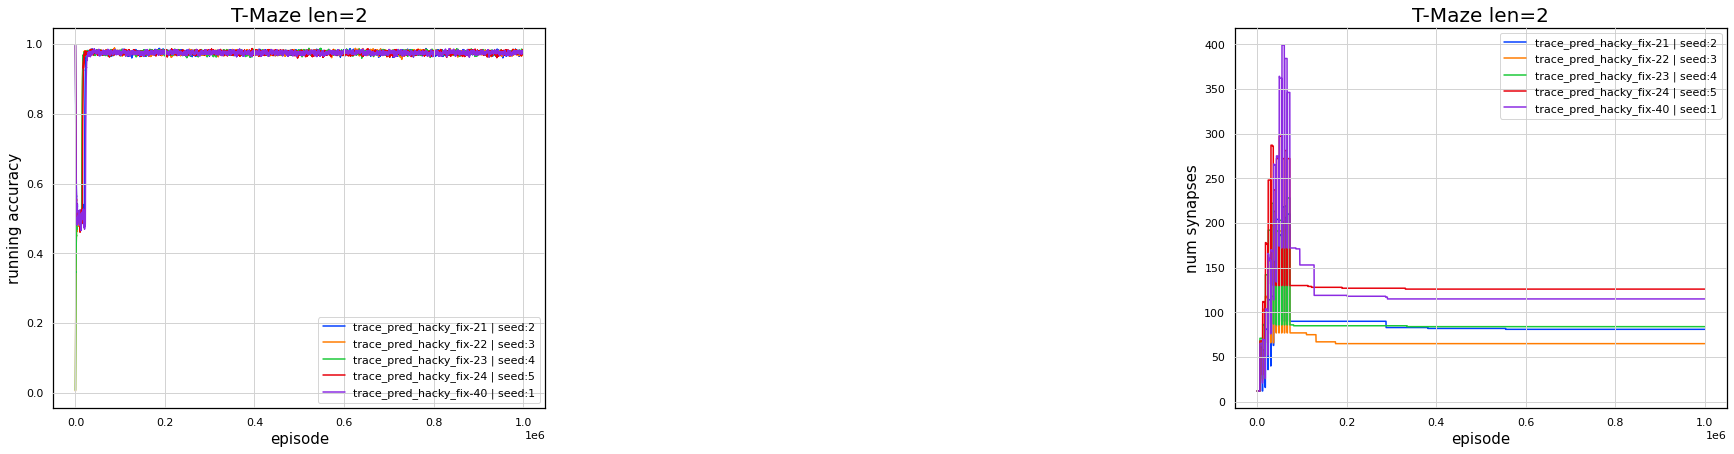

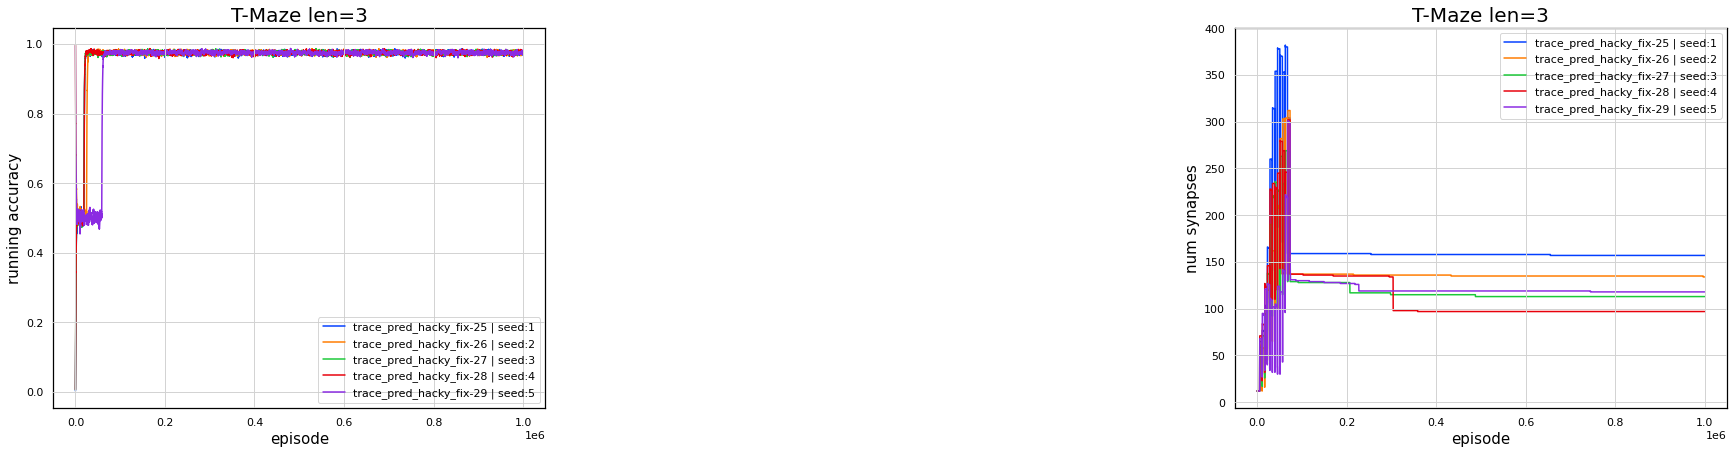

In [6]:
for tmaze_len in [2,3]:
    runs_base = pd.read_sql(f'select run,seed from runs where comment="{comment}" and tmaze_corridor_length={tmaze_len}', db.conn).values
    plot_runs(tmaze_len, runs_base)

In [7]:
db = DbAccessor('hshah1_tmaze_adaptive_new1', local=False)
pd.set_option('display.max_columns', 500)
comment = 'trace_pred_hacky_fix45'
pd.read_sql(f'select * from runs where comment="{comment}"', db.conn)
pd.read_sql(f'select * from runs inner join run_states on runs.run=run_states.run where comment="{comment}"', db.conn)

,add_features,comment,episode_gap,episode_length,epsilon,features_min_timesteps,gamma,lambda,max_episodes,name,num_layers,num_new_features,prediction_problem,run,seed,step_size,steps,tmaze_corridor_length,width,run,run_state,run_state_comments
0,true,trace_pred_hacky_fix45,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,41,2,3e-5,800000000,4,0,41,finished,
1,true,trace_pred_hacky_fix45,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,42,3,3e-5,800000000,4,0,42,finished,
2,true,trace_pred_hacky_fix45,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,43,4,3e-5,800000000,4,0,43,finished,
3,true,trace_pred_hacky_fix45,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,44,5,3e-5,800000000,4,0,44,finished,
4,true,trace_pred_hacky_fix45,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,45,1,3e-5,800000000,5,0,45,finished,
5,true,trace_pred_hacky_fix45,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,46,2,3e-5,800000000,5,0,46,finished,
6,true,trace_pred_hacky_fix45,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,47,3,3e-5,800000000,5,0,47,finished,
7,true,trace_pred_hacky_fix45,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,48,4,3e-5,800000000,5,0,48,killed,nan_prediction
8,true,trace_pred_hacky_fix45,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,49,5,3e-5,800000000,5,0,49,finished,
9,true,trace_pred_hacky_fix45,8,1000,0.05,80000,0.98,0.98,1000000,tmaze_adaptive_new1,0,10,true,50,1,3e-5,800000000,4,0,50,finished,


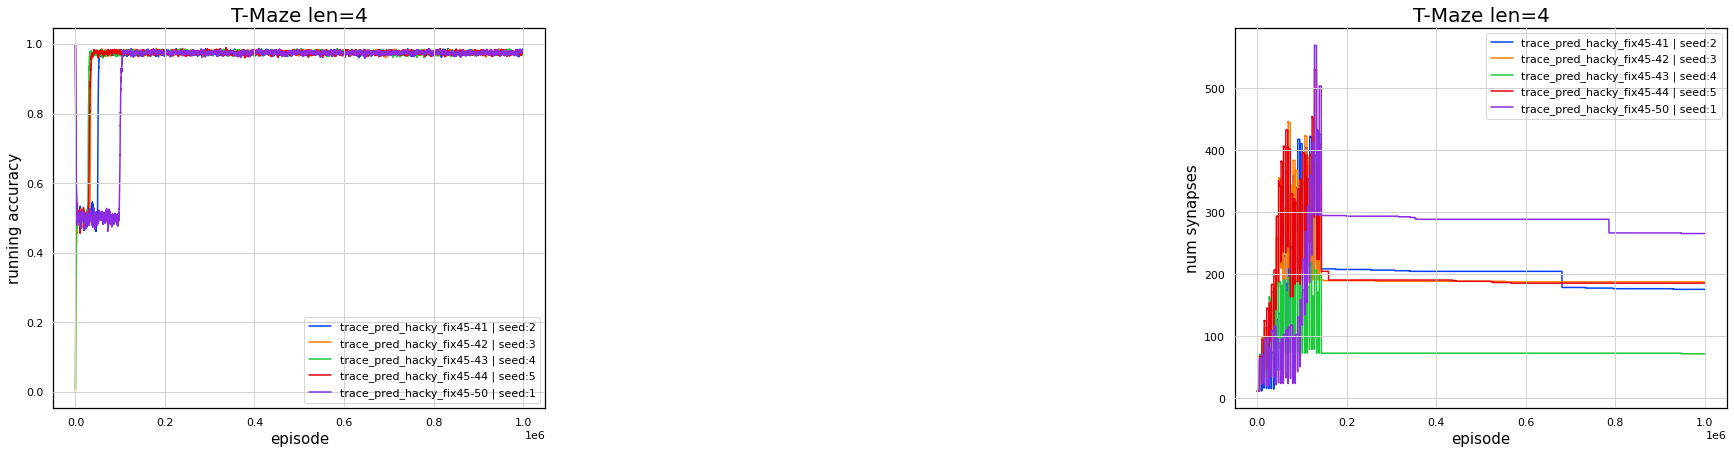

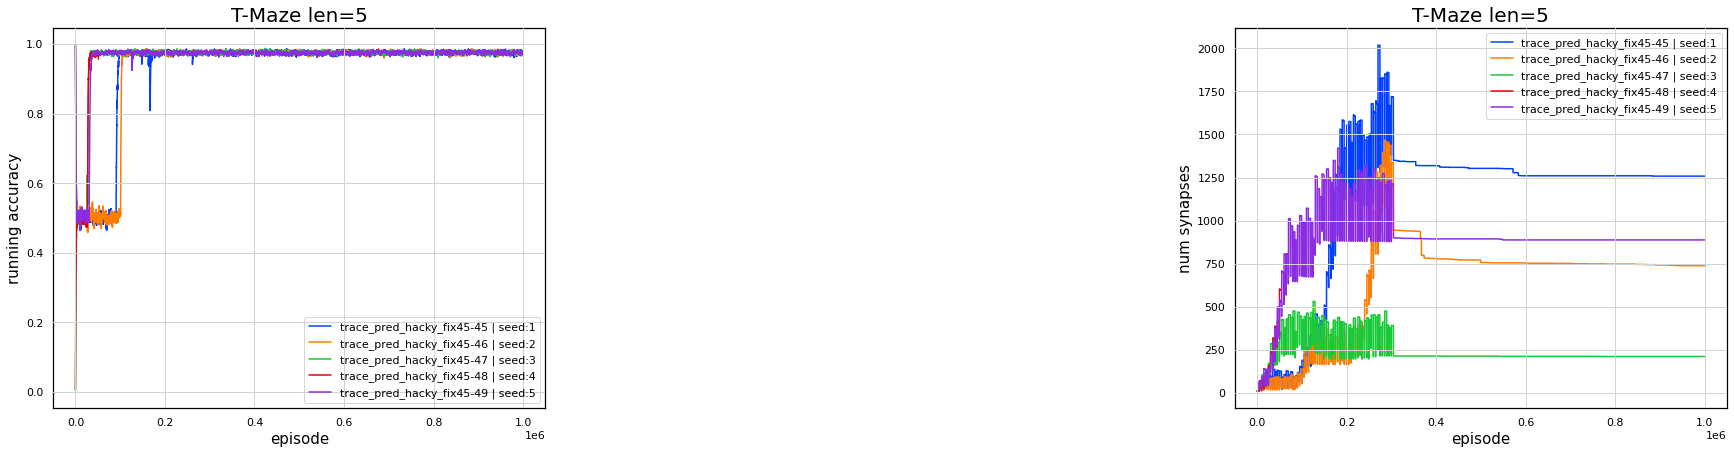

In [8]:
for tmaze_len in [4,5]:
    runs_base = pd.read_sql(f'select run,seed from runs where comment="{comment}" and tmaze_corridor_length={tmaze_len}', db.conn).values
    plot_runs(tmaze_len, runs_base)